# Polymer Chain Simulation in a Nanochannel with Flow
This Jupyter notebook performs a molecular dynamics simulation of a **semiflexible polymer chain** confined in a nanochannel using the [ESPResSo](https://espressomd.org/) simulation package.

The system supports various **channel cross-sections** (`circular`, `square`, `semi-circular`) and simulates the polymer under **homogeneous flow** along the x-direction. The goal is to analyze polymer conformations, density profiles, and structural statistics such as bond angles and stretching.

## Key Features
- Configurable channel geometry
- FENE bonds and WCA interactions
- Optional angle potentials for semiflexibility
- Time evolution of polymer under flow
- Visualization of chain density and 3D configuration

**Note:** This notebook is designed to be modular and user-editable for further studies in confined polymer dynamics.


## Part 1

Running the MD simulation using ESPResSo.

In [1]:
# === Importing Relevant Packages ===

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import espressomd
import espressomd.shapes
from espressomd.interactions import FeneBond, AngleCosine
from espressomd.observables import ParticlePositions
from espressomd.io.writer import h5md
import h5py

In [2]:
# === Simulation Parameters ===

CHANNEL_GEOMETRY = "circular"  # value options: "circular", "square", or "semi-circular" cross-sections
N_MONOMER = 150 #number of monomers in the chain; DO NOT CHANGE
PERSISTENCE_LENGTH = 10 #measures chain stiffness; value options: 0 (flexible chain) to 16
FLOW_STRENGTH = 0.05 #strength of the homogenous flow field; value options: 0 (no flow) to 0.2

SIMULATION_LENGTH = 3000 #total number of timesteps to run simulation for
FLOW_START = 1000 #timestep at which the homogenous flow field is applied
BOX_X, BOX_Y, BOX_Z = 200., 10., 10. #size of system; DO NOT CHANGE
TEMPERATURE = 0.2 #system temprature; DO NOT CHANGE
SEED = 40 #random seed for the system setup

#helper function to convert variables into strings for the output file name
def convert_num_to_str(number):
    num_str = str(number)
    return num_str.replace('.', '-')

#file name string
NAME = "_N" + convert_num_to_str(N_MONOMER) + "_p" + convert_num_to_str(PERSISTENCE_LENGTH) + "_" + CHANNEL_GEOMETRY + "_v" + convert_num_to_str(FLOW_STRENGTH)


In [3]:
# === System Setup ===

def initialize_system():
    system = espressomd.System(box_l=[BOX_X, BOX_Y, BOX_Z])
    system.time_step = 0.001
    system.thermostat.set_langevin(kT=TEMPERATURE, gamma=1.0, seed=SEED)
    print("System initialized.")
    return system


In [4]:
# === Define Channel ===

def define_channel(system):
    center = [BOX_X/2, BOX_Y/2, BOX_Z/2]
    axis = [1., 0., 0.]
    
    if CHANNEL_GEOMETRY == "circular":
        cyl = espressomd.shapes.Cylinder(center=center, direction=-1, axis=axis, radius=3, length=BOX_X, open=False)
        
        constrt = espressomd.constraints.ShapeBasedConstraint(shape = cyl, penetrable=False, particle_type=0)
        
        system.constraints.add(constrt)
    
    elif CHANNEL_GEOMETRY == "square":
        wall_x1 = espressomd.shapes.Wall(dist=0., normal=[1., 0., 0.])
        wall_x2 = espressomd.shapes.Wall(dist=-BOX_X, normal=[-1., 0., 0.])
        wall_y1 = espressomd.shapes.Wall(dist=2., normal=[0., 1., 0.])
        wall_y2 = espressomd.shapes.Wall(dist=-8., normal=[0., -1., 0.])
        wall_z1 = espressomd.shapes.Wall(dist=2., normal=[0., 0., 1.])
        wall_z2 = espressomd.shapes.Wall(dist=-8., normal=[0., 0., -1.])

        constrt_x1 = espressomd.constraints.ShapeBasedConstraint(shape = wall_x1, penetrable=False, particle_type=0)
        constrt_x2 = espressomd.constraints.ShapeBasedConstraint(shape = wall_x2, penetrable=False, particle_type=0)
        constrt_y1 = espressomd.constraints.ShapeBasedConstraint(shape = wall_y1, penetrable=False, particle_type=0)
        constrt_y2 = espressomd.constraints.ShapeBasedConstraint(shape = wall_y2, penetrable=False, particle_type=0)
        constrt_z1 = espressomd.constraints.ShapeBasedConstraint(shape = wall_z1, penetrable=False, particle_type=0)
        constrt_z2 = espressomd.constraints.ShapeBasedConstraint(shape = wall_z2, penetrable=False, particle_type=0)

        system.constraints.add(constrt_x1)
        system.constraints.add(constrt_x2)
        system.constraints.add(constrt_y1)
        system.constraints.add(constrt_y2)
        system.constraints.add(constrt_z1)
        system.constraints.add(constrt_z2)
        
    elif CHANNEL_GEOMETRY == "semi-circular":
        cyl = espressomd.shapes.Cylinder(center=[BOX_X/2, BOX_Y/2, BOX_Z/2-1], direction=-1, axis=axis, radius=4, length=BOX_X, open=False)
        wall_z2 = espressomd.shapes.Wall(dist=4., normal=[0., 0., 1.])
        
        constrt = espressomd.constraints.ShapeBasedConstraint(shape = cyl, penetrable=False, particle_type=0)
        constrt_z2 = espressomd.constraints.ShapeBasedConstraint(shape = wall_z2, penetrable=False, particle_type=0)
    
        system.constraints.add(constrt)
        system.constraints.add(constrt_z2)
        
    else:
        raise ValueError("Unknown channel geometry.")

    print(f"Channel geometry '{CHANNEL_GEOMETRY}' defined.")

#channels are non-penetratable and are set as a particle type different from the polymer


In [5]:
# === Initialize Polymer in a Straight Line ===

def initialize_polymer(system):
    bond_length_init = 0.3 #bond length to initiate polymer at; DO NOT CHANGE
    x_pos = np.arange(0.5, N_MONOMER * bond_length_init + 0.5, bond_length_init)
    y_pos = BOX_Y/2
    z_pos = BOX_Z/2

    for i in range(N_MONOMER):
        system.part.add(type=1, pos=[x_pos[i],y_pos,z_pos])

    print("Polymer chain initialized.")


In [6]:
# === Initialize Interactions ===

def set_interactions(system):
    # FENE bonded interactions between consecutive monomers
    fene = FeneBond(k=10., d_r_max=2., r_0=0.0)
    system.bonded_inter.add(fene) 
    for i in range(N_MONOMER - 1):
        system.part[i].add_bond((fene, i+1))

    # WCA interaction between any two monomers and between monomers and the channel
    system.non_bonded_inter[1,1].wca.set_params(epsilon=1., 
                                           sigma=0.3)
    system.non_bonded_inter[0,1].wca.set_params(epsilon=20,
                                           sigma=0.2) 
    
    print("Interactions defined (FENE and WCA).")


In [7]:
# === Warm Up And Optionally Initialize Semi-Flexibility ===

def warm_up_simulation(system):
    warm_time = 2000 #number of times to warm up for; DO NOT CHANGE
    warm_steps = 5 #number of timesteps to warm up for at every iteration
    wca_cap = 1.0
    wca_sigma = 0.3 
    for i in range(warm_time):
        system.force_cap = wca_cap
        system.integrator.run(warm_steps)
        wca_cap += 0.5
        
        if i>=600 and i%200==0:
            wca_sigma += 0.1
            system.non_bonded_inter[1,1].wca.set_params(epsilon=1., 
                                                   sigma=wca_sigma)
            if i==600:
                if PERSISTENCE_LENGTH > 0: #add bending energy according to persistence length
                    angle_cosine = AngleCosine(bend=PERSISTENCE_LENGTH*TEMPERATURE, phi0=np.pi) 
                    system.bonded_inter.add(angle_cosine)

                    for ii in range(N_MONOMER-2):
                        system.part[ii+1].add_bond((angle_cosine, ii, ii+2))
                    print("Interactions defined (angle).")
                    
    system.force_cap = 0
    print("Warm-up complete.")


In [8]:
# === Run the System ===

def run_simulation(system):
    steps = SIMULATION_LENGTH
    skip = 50 #saves all observables every "skip" time steps
    
    chain_edges_tot = np.zeros([int(steps/skip),2]) #tracking the max x-axis position of the molecule

    system.time_step = 0.005
    system.thermostat.set_langevin(kT=TEMPERATURE, gamma=1.0, seed=SEED)
    
    h5 = h5md.H5md(filename="./Positions" + NAME + ".h5", write_pos=True, write_ordered=True)
    for i in range(steps):
        system.integrator.run(200)

        if i%skip==skip-1:
            h5.write()
            positions = ParticlePositions(ids=system.part[0:N_MONOMER].id)
            
            positions_calc = np.asarray(positions.calculate())
            positions_calc = positions_calc.reshape((N_MONOMER,3))

            x_max = np.amax(positions_calc[:,0])
            x_min = np.amin(positions_calc[:,0])
            
            chain_edges_tot[int((i+1)/skip)-1,:] = [x_min, x_max]
            
            if i%1000==1000-1:
                print(f"Progress: {i}/{steps} steps")

        if i==FLOW_START and FLOW_STRENGTH>0:
            field = espressomd.constraints.HomogeneousFlowField(gamma=1,u=[FLOW_STRENGTH,0,0])
            system.constraints.add(field)
            
    np.savetxt("./Chain_edges" + NAME + ".txt", chain_edges_tot, delimiter=',')
    
    h5.close()
    if i > FLOW_START:
        system.constraints.remove(field)
        
    print("Simulation complete and data saved.")


In [9]:
# === Making the simulation ===

def main():
    system = initialize_system()
    define_channel(system)
    initialize_polymer(system)
    set_interactions(system)
    warm_up_simulation(system)
    run_simulation(system)

if __name__ == "__main__":
    main()
    

System initialized.
Channel geometry 'circular' defined.
Polymer chain initialized.
Interactions defined (FENE and WCA).
Interactions defined (angle).
Warm-up complete.
Progress: 999/3000 steps
Progress: 1999/3000 steps
Progress: 2999/3000 steps
Simulation complete and data saved.


## Part 2

Analyzing the MD simulation results.

In [11]:
#Read the generated h5md position file

h5file = h5py.File("./Positions" + NAME + ".h5", 'r')
dset1 = h5file['particles']
dset2 = dset1['atoms']
dset3 = dset2['position']
positions = dset3['value']

print(positions.shape)

#Read the generated chain edges file

chain_edges = np.loadtxt('Chain_edges' + NAME + '.txt', delimiter=',')

print(chain_edges.shape)

#Compute bond angles from monomer positions

angles = np.arccos(np.diff(positions[:,:,0],n=1,axis=1)/(np.diff(positions[:,:,0],n=1,axis=1)**2 + np.diff(positions[:,:,1],n=1,axis=1)**2 + np.diff(positions[:,:,2],n=1,axis=1)**2)**(1/2))

(2000, 150, 3)
(2000, 2)


Text(0.5, 0, 'Position along x (channel axis)')

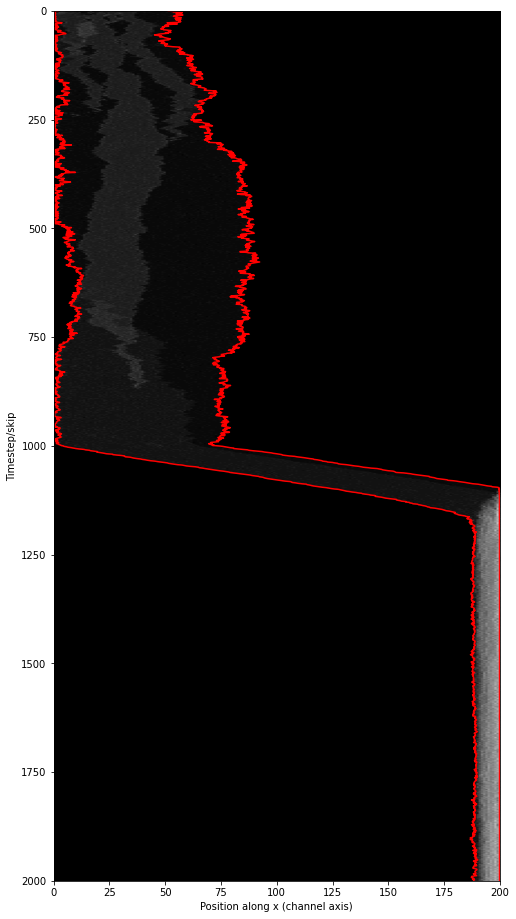

In [15]:
#create kymograph representation of chain density along channel axis over time

x_bins = 200 #number of bins over which to calculate density along x; ideally set to BOX_X/2, BOX_X, or BOX_X*2
t_length = positions.shape[0] #length of simulation divided by skip

density = np.zeros((t_length,x_bins))

for i in range(t_length):
    density[i,:] = np.histogram(positions[i,:,0], bins=np.arange(x_bins+1)*BOX_X/x_bins, density=True)[0]

density = density/np.amax(density)*255
density = density.astype(np.uint8)

fig, ax = plt.subplots(figsize=(8, 16))
im = Image.fromarray(density)
ax.imshow(im,extent=[0,BOX_X,t_length,0],cmap='gray',aspect='auto')
ax.plot(chain_edges[:,0],np.arange(t_length), 'r') #overlay the left chain edge
ax.plot(chain_edges[:,1],np.arange(t_length), 'r') #overlay the right chain edge
ax.set_ylabel('Timestep/skip')
ax.set_xlabel('Position along x (channel axis)')

(0.0, 10.0)

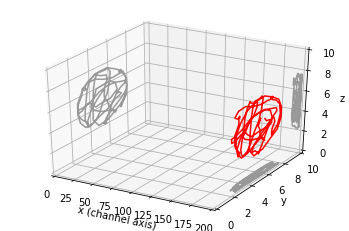

In [16]:
#Plot 3D monomer positions at given time index and projections along the x-y, x-z, and y-z planes

index = 1750 #integer between 0 and t_length

pos = positions[index,:,:]

ax = plt.axes(projection='3d')
ax.plot3D(pos[:,0], pos[:,1], np.zeros((N_MONOMER)), color = '0.6')
ax.plot3D(np.zeros((N_MONOMER)), pos[:,1], pos[:,2], color = '0.6')
ax.plot3D(pos[:,0], np.ones((N_MONOMER))*BOX_Y, pos[:,2], color = '0.6')
ax.plot3D(pos[:,0], pos[:,1], pos[:,2], 'r')
ax.set_xlabel('x (channel axis)', labelpad=0)
ax.set_ylabel('y', labelpad=0)
ax.set_zlabel('z', labelpad=0)
ax.set_xlim(0,BOX_X)
ax.set_ylim(0,BOX_Y)
ax.set_zlim(0,BOX_Z)

(0.0, 200.0)

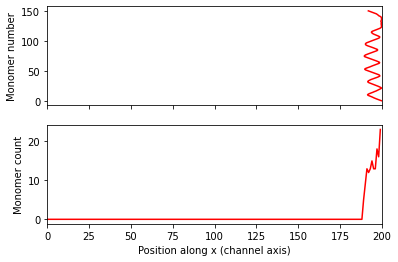

In [17]:
#Plot monomer x-axis position vs monomer number

fig, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(positions[index,:,0],np.arange(N_MONOMER)+1, 'r')
axs[0].set_ylabel('Monomer number')
axs[0].set_xlim(0,BOX_X)

#Plot monomer count along x-axis

axs[1].plot(np.arange(0,BOX_X,BOX_X/x_bins),density[index,:]/np.sum(density[index,:])*N_MONOMER, 'r')
axs[1].set_ylabel('Monomer count')
axs[1].set_xlabel('Position along x (channel axis)')
axs[1].set_xlim(0,BOX_X)


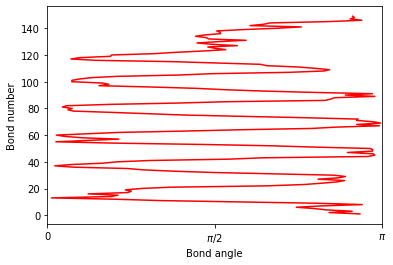

In [18]:
#Plot bond angle vs bond number (N_MONOMER - 1)

plt.plot(angles[index,:],np.arange(N_MONOMER-1)+1, 'r')
plt.ylabel('Bond number')
plt.xlabel('Bond angle')
plt.xlim(0,np.pi)
xpositions = (0, np.pi/2, np.pi)
xlabels = ("0", "$\pi$/2", "$\pi$")
plt.xticks(xpositions, xlabels)
plt.show()

## Conclusion
This simulation provides insight into the behavior of a semiflexible polymer confined to a nanochannel under flow. The outputs include trajectory data, kymographs, and structural visualizations.

This code can be extended to:
- Include multiple chains (code is provided for two chains in a separate Jupyter notebook in this repository)
- Vary flow profiles or confinement geometry dynamically
- Study scaling with chain length or channel size

Feel free to fork, adapt, and extend for your specific research or educational purposes.

---
_Originally developed using ESPResSo by Lili Zeng_